In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon

from scipy.optimize import fsolve
from scipy.linalg import cho_solve, cho_factor
from scipy.interpolate import interp1d

from matplotlib import cm
from matplotlib.ticker import LinearLocator

from scipy.stats import qmc

from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

In [2]:
from sample import *
from inference import *

## 1. Select Q, t range

/tmp/ipykernel_3434518/2388141159.py:36: UserWarning: linewidths is ignored by contourf
  ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), linewidths=1, extend='both', zorder=-15)
/tmp/ipykernel_3434518/2388141159.py:95: RuntimeWarning: divide by zero encountered in log
  logQ_eval = np.log(Q_eval)


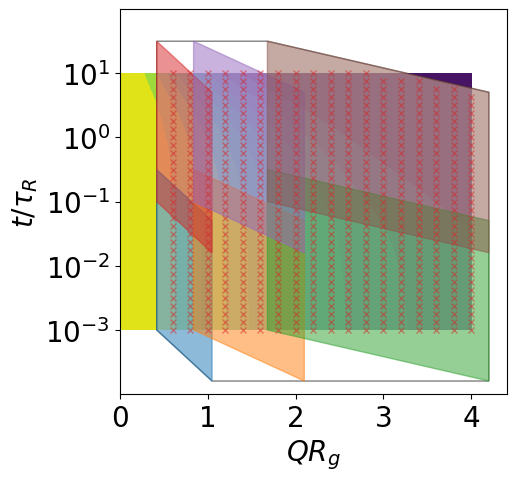

In [3]:
n_Q = 8 # Number of Q (for each detector angle)
n_t = 22
list_Q_0 = np.array([0.5, 1, 2, 0.5, 1, 2])/5*4.2 # Smallest Q of each detector angle 
r_Q_max = 2.5 # Ratio of Q0 to Qmax for each detector angle
r_Q = np.linspace(1, r_Q_max, n_Q) # Ratio of Q0 to Qmax for interpolation

list_t_0 = np.array([1,1,1,100,100,100])*1e-3 # t for each detector angle
r_t = np.logspace(0, 2.5, n_t)
n_Qt = len(list_Q_0) * len(r_Q) * len(r_t)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'] # Colors for each detector angle

# background
n_Q = 21
n_t = 33

t = (np.arange(n_t))/n_t*12
t = 10**(np.linspace(-3,1, n_t))
b = 0.5
N = 20
D = 0.1
Rg = np.sqrt(N*b**2/6)

QRg = np.linspace(0, 4, n_Q)
Q = QRg/Rg

Q_grid, t_grid = np.meshgrid(QRg, t)
Q_eval = Q_grid.flatten()
t_eval = t_grid.flatten()
Q_color = Q_eval
t_color = t_eval

sqt = f_sqt_chain(Q_grid, t_grid, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N
ax.contourf(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), linewidths=1, extend='both', zorder=-15)
# ax.contour(Q_grid, t_grid, sqt, levels=np.linspace(0, 1, 11), linewidths=1, extend='both',colors='k',lw=2, zorder=-10)

list_Qt = [] # List of Q, t values for each detector angle
list_logQt = []
for i in range(len(list_Q_0)):
    Q_0 = list_Q_0[i]
    t_0 = list_t_0[i]
    
    Q_grid_obs, t_grid_obs = np.meshgrid(Q_0 * r_Q, t_0 * r_t)
    rQ_grid_obs = (Q_grid_obs / Q_0)**2
    t_grid_obs = t_grid_obs / rQ_grid_obs
    Q_i = Q_grid_obs.flatten()
    t_i = t_grid_obs.flatten()
    Qt = np.array([Q_i, t_i]).T
    index_valid = np.where((t_i >1e-3) & (t_i<1e1)) # Remove invalid points where t is too small
    
    logQt = np.array([np.log(Q_i), np.log(t_i)]).T
    list_Qt.append(Qt)
    list_logQt.append(logQt)
    
    # ax.plot(Q_i, t_i, 'o', markersize=2, alpha=0.25, zorder=5, color=colors[i])
    hull = ConvexHull(logQt)
    # Plot the convex hull as a filled patch
    polygon = Polygon(Qt[hull.vertices], closed=True, edgecolor=colors[i], facecolor=colors[i], alpha=0.5, zorder=-0)
    ax.add_patch(polygon)
    
    # Q_i = Q_i[index_valid]  
    # t_i = t_i[index_valid]
    Qt = np.array([Q_i, t_i]).T

list_Qt = np.concatenate(list_Qt)
list_Qt_flattened = list_Qt.reshape(-1, 2)
list_logQt = np.concatenate(list_logQt)
list_logQt_flattened = list_logQt.reshape(-1, 2)

hull = ConvexHull(list_logQt_flattened)

# Plot the convex hull as a filled patch
polygon = Polygon(list_Qt_flattened[hull.vertices], closed=True, edgecolor=[0,0,0,0.25], facecolor=[1,1,1,0.25], alpha=0.5, zorder=-5)
ax.add_patch(polygon)

ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim([0, 4])
ax.set_ylim([1e-4, 100])
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_aspect('equal')

# From Q_eval, t_eval, select the points that are inside the convex hull
points = np.log(list_Qt_flattened[hull.vertices])
# Create a Delaunay triangulation of the convex hull vertices
tri = Delaunay(points)

# Transform Q_eval and t_eval into logarithmic space
logQ_eval = np.log(Q_eval)
logt_eval = np.log(t_eval)
logQt_eval = np.array([logQ_eval, logt_eval]).T

# Check if points are inside the convex hull in logarithmic space
inside_hull = tri.find_simplex(logQt_eval) > -1

# Filter the points that are inside the convex hull
Q_eval = Q_eval[inside_hull]
t_eval = t_eval[inside_hull]

ax.plot(Q_eval, t_eval, 'x', markersize=5, alpha=0.5, zorder=10, color='C3')


## 2. Prepare Observations and GT

In [4]:
hull.vertices

array([ 696,    0,    7,  359, 1055, 1048], dtype=int32)

In [5]:
# evaluate SQT for each Q, t value in list_Qt_flattened
Q_obs = list_Qt_flattened[:, 0]
t_obs = list_Qt_flattened[:, 1]
sqt = f_sqt_chain_offgrid(Q_obs, t_obs, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N

# evaluate SQT for each Q, t value in Q_eval, t_eval
sqt_eval = f_sqt_chain_offgrid(Q_eval, t_eval, N=N, b=b, D=D, tau_R=1.0, p_max=100)/N

# assign errorbar
bg = 0.002
N_count_obs = len(Q_obs)*500
N_count_eval = len(Q_eval)*500
seed = 114514

sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_offgrid(Q_obs, t_obs, N_count=N_count_obs, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)
sqt_sample_eval, Delta_sqt_sample_eval, sqt_GT = f_sqt_sample_offgrid(Q_eval, t_eval, N_count=N_count_eval, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)

## 3. Inference

In [6]:
sqt_exp = sqt_sample
delta_sqt_exp = Delta_sqt_sample

# # append dataset
# Q_app = np.ones(33)*0.01
# t_app = np.logspace(-3, 1, 33)
# sqt_app = np.ones(33)
# delta_sqt_app = np.ones(33)*0.01

# # append the dataset to the original data
# Q_obs_app = np.concatenate((Q_obs, Q_app))
# t_obs_app = np.concatenate((t_obs, t_app))
# sqt_exp_app = np.concatenate((sqt_exp, sqt_app))
# delta_sqt_exp_app = np.concatenate((delta_sqt_exp, delta_sqt_app))

lambda_ = 0.25
mu_ = lambda_

N_Prony = 25
# list_tau_i = np.exp(np.linspace(-4,2,N_Prony))
list_tau_i = 10**(np.linspace(-1,3,N_Prony))
tau = np.array(list_tau_i)
bg_mode = False

A_GPR, K_GPR, sqt_GPR = bayesian_inference(
    sqt_exp, delta_sqt_exp, np.log(Q_obs), t_obs, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode
)

L: 584, M: 1056, N: 25


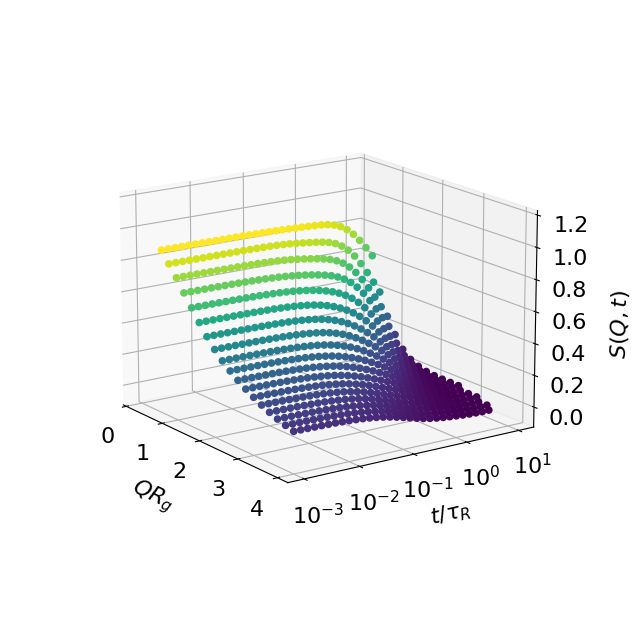

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

# surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
# ax.scatter(Q, np.log10(t), sqt_GPR, c=sqt, alpha=1)
ax.scatter(Q_eval, np.log10(t_eval), sqt_GPR, c=sqt_GT, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

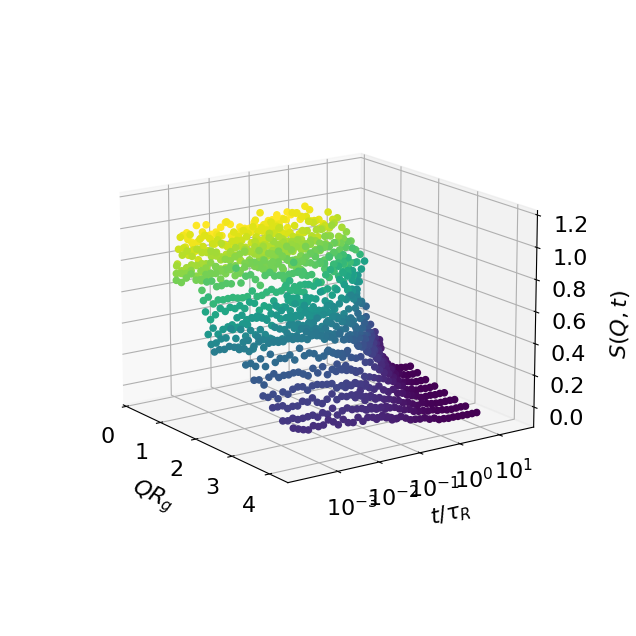

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.

# scatter = ax.scatter(Q_grid, np.log10(t_grid), sqt_exp.T-sqt_GT.T, color='k', alpha=0.5)

# surf_gt = ax.plot_surface(Q_grid, np.log10(t_grid), sqt_GT.T, alpha=1, cmap=cm.viridis)
# ax.scatter(Q, np.log10(t), sqt_GPR, c=sqt, alpha=1)
ax.scatter(Q_obs, np.log10(t_obs), sqt_sample, c=sqt, alpha=1)
        
# ax.plot(Q_grid[0,:], np.log10(t_grid)[0,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[-1,:], np.log10(t_grid)[-1,:], np.zeros_like(Q_grid[0,:]), color='b', alpha=1)
# ax.plot(Q_grid[:,0], np.log10(t_grid)[:,0], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)
# ax.plot(Q_grid[:,-1], np.log10(t_grid)[:,-1], np.zeros_like(Q_grid[:,0]), color='b', alpha=1)

# Customize the z axis.
# ax.set_zlim(-0.15, 0.15)

ax.set_xlabel(r'$QR_g$', fontsize=16, labelpad=25)
ax.set_ylabel(r'$t/\tau_R$', fontsize=16, labelpad=25)
ax.set_zlabel(r'$S(Q,t)$', fontsize=16, labelpad=25)

ax.set_yticks([-3, -2, -1, 0, 1])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e-2, 1e-1, 1e0, 1e1]])

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_zlim(-0.1,1.2)

ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.set_box_aspect(None, zoom=0.75)
ax.view_init(16, 325)

# plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Text(0, -3, '$10^{-3}$'), Text(0, 1, '$10^{1}$')]

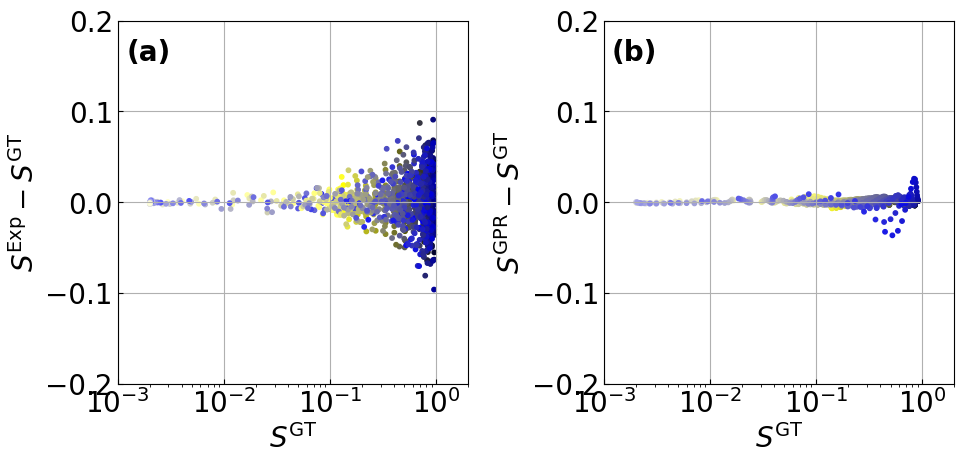

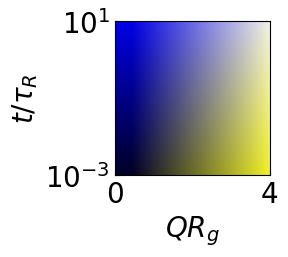

In [9]:
panels_list = ['(a)', '(b)', '(c)']

# Create a 2D RGB color scheme
norm = plt.Normalize(vmin=Q_obs.min(), vmax=Q_obs.max())
norm_t = plt.Normalize(vmin=np.log10(t_obs).min(), vmax=np.log10(t_obs).max())
colors_obs = plt.cm.viridis(norm(Q_obs))
colors_obs[:, 0] = norm(Q_obs)  # Red channel controlled by Q
colors_obs[:, 1] = norm(Q_obs)  # Red channel controlled by Q
colors_obs[:, 2] = norm_t(np.log10(t_obs))  # Blue channel controlled by log10(t)

colors_eval = plt.cm.viridis(norm(Q_eval))
colors_eval[:, 0] = norm(Q_eval)  # Red channel controlled by Q
colors_eval[:, 1] = norm(Q_eval)  # Red channel controlled by Q
colors_eval[:, 2] = norm_t(np.log10(t_eval))  # Blue channel controlled by log10(t)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.scatter(sqt, (sqt_exp-sqt), s=10, c=colors_obs)
ax.set_xlabel('$S^\mathrm{GT}$', fontsize=20)
ax.set_ylabel('$S^\mathrm{Exp}-S^\mathrm{GT}$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlim(1e-3,2)
ax.set_ylim(-0.2,0.2)
ax.set_xscale('log')
ax.grid('on')
ax.text(0.15, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

ax = fig.add_subplot(122)
ax.scatter(sqt_GT, (sqt_GPR-sqt_GT), s=10, c=colors_eval)
ax.set_xlabel('$S^\mathrm{GT}$', fontsize=20)
ax.set_ylabel('$S^\mathrm{GPR}-S^\mathrm{GT}$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlim(1e-3,2)
ax.set_ylim(-0.2,0.2)
ax.set_xscale('log')
ax.grid('on')
ax.text(0.15, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

plt.tight_layout(pad=2)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)

q_grid = np.linspace(0, 4, 100)
t_grid = 10**(np.linspace(-3,1, 100))
Q_grid, t_grid = np.meshgrid(q_grid, t_grid)
colors = plt.cm.viridis(norm(Q_grid))
colors[:, :, 0] = norm(Q_grid)  # Red channel controlled by Q
colors[:, :, 1] = norm(Q_grid)  # Red channel controlled by Q
colors[:, :, 2] = norm_t(np.log10(t_grid))  # Blue channel controlled by log10(t)
ax.imshow(colors, extent=(0, 4, -3, 1), aspect='auto', origin='lower')
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$QR_g$', fontsize=20)
ax.set_ylabel(r'$t/\tau_R$', fontsize=20)
ax.set_xticks([0, 4])
ax.set_yticks([-3, 1])
ax.set_xticklabels([f'{i}' for i in [0, 4]])
ax.set_yticklabels([f'$10^{{{int(np.log10(y))}}}$' for y in [1e-3, 1e1]])


## 4. Efficiency

In [10]:
n_repeat = 1
list_N_count = np.logspace(3.5,6.5,16).astype(int)
list_chi_sq_exp_gt = []
list_chi_sq_GPR_gt = []
list_mse_exp_gt = []
list_mse_GPR_gt = []
for N_count in list_N_count:
    mse_exp_gt = 0
    mse_GPR_gt = 0
    chi_sq_exp_gt = 0
    chi_sq_GPR_gt = 0
    for i in range(n_repeat):
        sqt_sample, Delta_sqt_sample, sqt = f_sqt_sample_offgrid(Q_obs, t_obs, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)
        sqt_sample_eval, Delta_sqt_sample_eval, sqt_GT = f_sqt_sample_offgrid(Q_eval, t_eval, N_count=N_count, N=N, b=b, D=D, tau_R=1.0, p_max=100, seed=seed, bg = bg)

        sqt_exp = sqt_sample
        delta_sqt_exp = Delta_sqt_sample
        A_GPR, K_GPR, sqt_GPR = bayesian_inference(
                sqt_exp, delta_sqt_exp, Q_obs, t_obs, Q_eval, t_eval, tau, mu_, lambda_
            )
    
        mse_exp_gt += np.mean((sqt_exp-sqt)**2)
        mse_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2)
        
        chi_sq_exp_gt += np.mean((sqt_exp-sqt)**2/delta_sqt_exp**2)
        chi_sq_GPR_gt += np.mean((sqt_GPR-sqt_GT)**2/Delta_sqt_sample_eval**2)
    
    mse_exp_gt /= n_repeat
    mse_GPR_gt /= n_repeat
    chi_sq_exp_gt /= n_repeat
    chi_sq_GPR_gt /= n_repeat
    
    list_chi_sq_exp_gt.append(chi_sq_exp_gt)
    list_chi_sq_GPR_gt.append(chi_sq_GPR_gt)
    list_mse_exp_gt.append(mse_exp_gt)
    list_mse_GPR_gt.append(mse_GPR_gt)

L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25
L: 584, M: 1056, N: 25


In [11]:
# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(np.log(list_mse_GPR_gt), np.log(list_N_count), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(list_N_count)
for i in range(len(list_mse_exp_gt)):
    H_exp_gt_i = np.log(list_mse_exp_gt[i])
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))
    
from scipy.optimize import curve_fit

# plot the time required for the GPR and the experimental data to reach the same relative entropy
# fit the log(list_N_count) - log(list_mse_GPR_gt) with a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the data for GPR
popt_gpr, pcov_gpr = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_GPR_gt))
# Generate x values for the fitted line
x_fit_gpr = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_gpr = linear_func(x_fit_gpr, *popt_gpr)

# Fit the data for Exp
popt_exp, pcov_exp = curve_fit(linear_func, np.log(list_N_count), np.log(list_mse_exp_gt))
# Generate x values for the fitted line
x_fit_exp = np.linspace(np.log(list_N_count[0]), np.log(list_N_count[-1]), 100)
# Calculate the fitted y values
y_fit_exp = linear_func(x_fit_exp, *popt_exp)

# Estimate the x_fit_gpr and x_fit_exp given the same y
y_target_values = np.linspace(np.min(np.log(list_mse_GPR_gt)), np.max(np.log(list_mse_GPR_gt)), 10)
y_target_values = np.log(list_mse_GPR_gt)

N_count_est_gpr_values = []
N_count_est_exp_values = []
list_ratio_N = []

for i, y_target in enumerate(y_target_values):
    # Find the corresponding x values for the target y value
    # x_est_gpr = (y_target - popt_gpr[1]) / popt_gpr[0]
    x_est_gpr = np.log(list_N_count[i])
    x_est_exp = (y_target - popt_exp[1]) / popt_exp[0]

    # Convert the log values back to the original scale
    N_count_est_gpr = np.exp(x_est_gpr)
    N_count_est_exp = np.exp(x_est_exp)

    N_count_est_gpr_values.append(N_count_est_gpr)
    N_count_est_exp_values.append(N_count_est_exp)
    ratio_N = N_count_est_exp/N_count_est_gpr
    list_ratio_N.append(ratio_N)

print("Estimated N_count for GPR:", N_count_est_gpr_values)
print("Estimated N_count for Exp:", N_count_est_exp_values)

Estimated N_count for GPR: [3161.9999999999986, 5010.999999999999, 7942.999999999999, 12589.0, 19952.000000000007, 31621.999999999975, 50118.000000000015, 79431.99999999994, 125891.99999999994, 199525.99999999985, 316227.00000000006, 501187.0000000001, 794327.9999999991, 1258924.9999999984, 1995261.9999999986, 3162276.9999999963]
Estimated N_count for Exp: [185073.9358321144, 320910.1622375761, 444380.0465312986, 592338.127958671, 738288.8823858234, 1035707.6968047852, 1525167.8295073048, 2617263.5531016975, 3161610.832228553, 4123697.535887188, 4406365.705750986, 4137922.400038371, 3774725.4576195558, 3593677.2476326264, 4522038.091300896, 4493339.667840421]


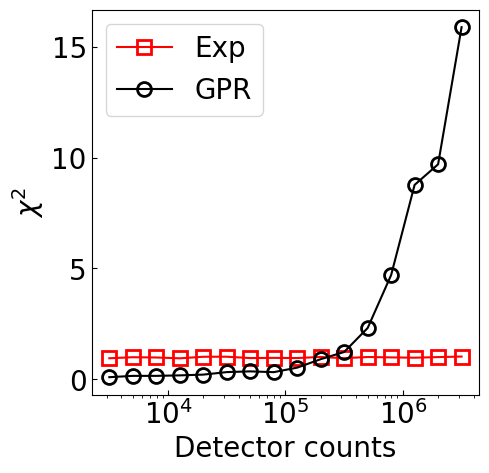

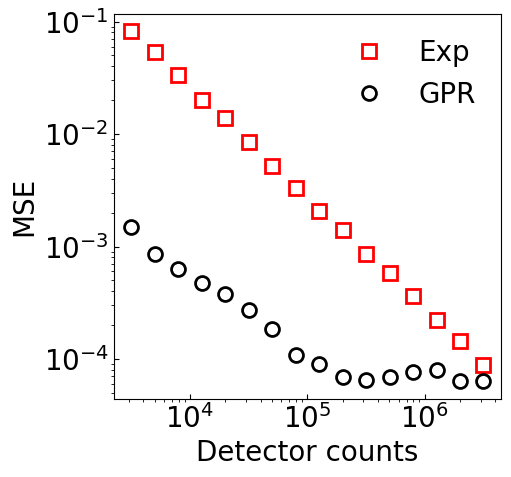

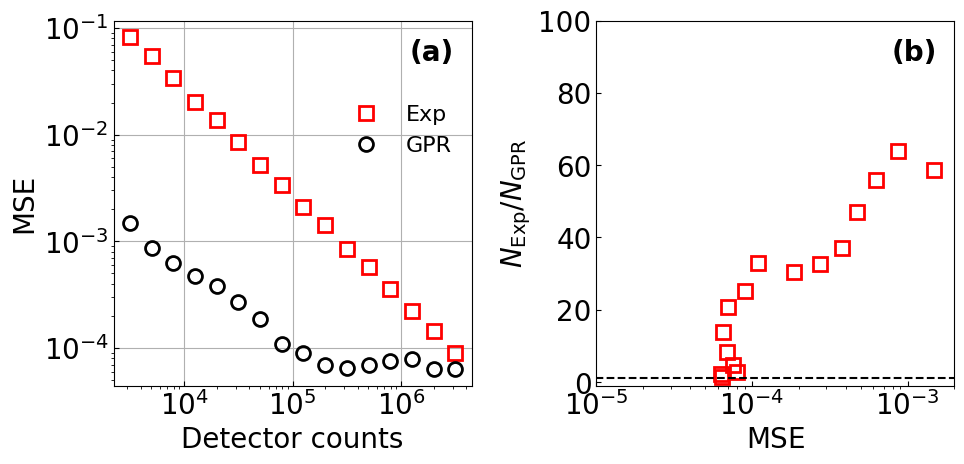

In [12]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_chi_sq_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_chi_sq_GPR_gt, '-o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel(r'$\chi^2$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=20, frameon=False)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

ax.plot(list_N_count, list_mse_exp_gt, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
# ax.plot(np.exp(x_fit_exp), np.exp(y_fit_exp), '-', color='r',  fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(list_N_count, list_mse_GPR_gt, 'o', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label='GPR')
# ax.plot(np.exp(x_fit_gpr), np.exp(y_fit_gpr), '-', color='k',  fillstyle='none', ms=10, markeredgewidth=2)
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Detector counts', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.legend(fontsize=16, frameon=False, loc='right', bbox_to_anchor=(1, 0.7))
ax.text(0.95, 0.95, panels_list[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

ax = fig.add_subplot(122)
ax.plot(np.exp(y_target_values), list_ratio_N, 's', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([1e-6,1e-2], [1, 1], '--', color='k',  fillstyle='none', ms=10, markeredgewidth=2, label = r'$t_\mathrm{Exp}$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([2e-5,2e-3])
ax.set_ylim([-1, 100])
ax.tick_params(direction='in', labelsize=20)
ax.set_xticks([1e-5,1e-4,1e-3])
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{MSE}}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Exp}/N_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=9)
ax.xaxis.set_minor_locator(locmin)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.text(0.95, 0.95, panels_list[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', color='k')

plt.tight_layout(pad=2)

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(121)

# ax.plot(time_gpr, list_mse_exp_gt, '-s', color='r',  fillstyle='none', ms=10, markeredgewidth=2, label='Exp')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Detector counts', fontsize=20)
# ax.set_ylabel('MSE', fontsize=20)
# ax.tick_params(direction='in', labelsize=20)
# ax.legend(fontsize=20, frameon=False)